# T/S Diagram from SOSE

In [10]:
from dask.distributed import Client

client = Client("tcp://10.32.16.35:41555")
client

Client Scheduler: tcp://10.32.16.35:41555 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 20 Cores: 40 Memory: 230.00 GB


In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
%matplotlib inline

In [39]:
ds = xr.open_zarr(gcsfs.GCSFileSystem(requester_pays=True).get_mapper('pangeo-ecco-sose'), consolidated=True)

In [40]:
coords = ds.coords.to_dataset().reset_coords()
dsr = ds.reset_coords(drop=True)

In [41]:
lower_lat = 0
upper_lat = 78
left_lon = 1788
right_lon = 2159

In [42]:
#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))

In [43]:
salt = dsr.SALT.isel(**lat_range, **lon_range)
temp = dsr.THETA.isel(**lat_range, **lon_range)

# Juliu's XMovie package

In [8]:
from xmovie import Movie

In [14]:
def custom_plotfunc(dsr, fig, tt, salt=dsr.SALT, temp=dsr.THETA, Z=dsr.Z):

    salt = salt.isel(time=tt, **lat_range, **lon_range)
    temp = temp.isel(time=tt, **lat_range, **lon_range)
    
    _, _, lev_broadcasted = xr.broadcast(salt, temp, Z)
    
    ax = fig.subplots()
    
    scat = ax.scatter(salt, temp, c=abs(lev_broadcasted), marker='.', s=0.5)#, alpha=0.5)<- cheap way to look at vol weighted
    fig.colorbar(scat, label='Depth [m]', shrink=0.8, ticks=np.arange(0, 6000, 1000))

    ax.set_xlim(33.4, 35)
    ax.set_ylim(-2, 1)

    ax.set_xlabel('Salinity [psu]')
    ax.set_ylabel('Potential Temperature [˚C]')
    ax.set_title('T-S Diagram of Weddell Gyre \n 2005-2010 (SOSE)', fontsize=20)
    
    fig.subplots_adjust(top=0.8)
    
    return ax, scat

In [15]:
#creating movie object
mov = Movie(dsr.time, plotfunc=custom_plotfunc, 
            salt=dsr.SALT, temp=dsr.THETA, 
            Z=dsr.Z, input_check=False, dpi=150)
#mov.save('movie.mp4')

In [12]:
#frame preview
mov.preview(3)

In [16]:
#create a movie!

#dsr = dsr.isel(time=slice(0,21))

mov = Movie(dsr.time, plotfunc=custom_plotfunc, 
            salt=dsr.SALT, 
            temp=dsr.THETA, 
            Z=dsr.Z, input_check=False)
mov.save('movie_full.mp4', progress=True)


Movie created at movie_full.mp4


# xhistogram T/S Diagram from SOSE

In [8]:
from xhistogram.xarray import histogram
import numpy as np
from matplotlib.colors import LogNorm

In [44]:
salt_bins = np.linspace(33, 35, 100)
theta_bins = np.linspace(-2.2, 4, 100)
delta_salt = salt_bins[1] - salt_bins[0]
delta_theta = theta_bins[1] - theta_bins[0]

vol = (coords.hFacC * coords.rA * coords.drF).isel(**lat_range, **lon_range)

/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


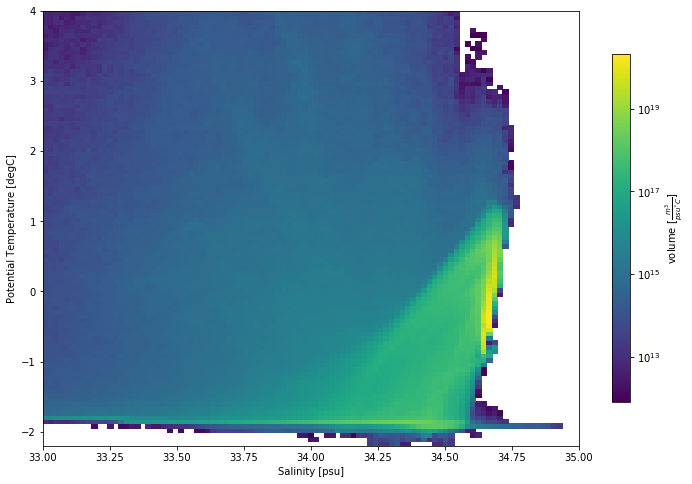

In [45]:
#having `time` dim in the `histogram` func sums over time
ts_hist = histogram(temp, salt, bins=[theta_bins, salt_bins],
                    weights=vol, dim=['XC', 'YC', 'Z', 'time']).rename({'THETA_bin':'theta_bin',
                                                                        'SALT_bin':'salt_bin'}) / (delta_salt * delta_theta)
ts_hist.where(ts_hist>0).plot(norm=LogNorm(), figsize=(12,8), cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

In [46]:
ts_hist = histogram(temp, salt, bins=[theta_bins, salt_bins],
                    weights=vol, dim=['XC', 'YC', 'Z']).rename({'THETA_bin':'theta_bin',
                                                                        'SALT_bin':'salt_bin'}) / (delta_salt * delta_theta)
ts_hist

<xarray.DataArray 'histogram_THETA_SALT' (time: 438, theta_bin: 99, salt_bin: 99)>
dask.array<truediv, shape=(438, 99, 99), dtype=float64, chunksize=(1, 99, 99), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * theta_bin  (theta_bin) float64 -2.169 -2.106 -2.043 ... 3.843 3.906 3.969
  * salt_bin   (salt_bin) float64 33.01 33.03 33.05 33.07 ... 34.95 34.97 34.99

In [47]:
#taking hist mean over `time` takes average (notice the scales are diff in either plots)
ts_hist_mean = ts_hist.mean(dim='time')

Text(0, 0.5, 'Potential Temperature [˚C]')

/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


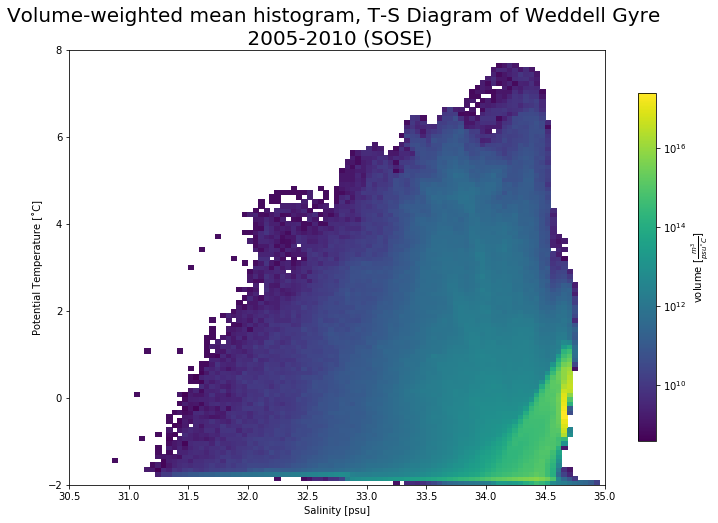

In [13]:
ts_hist_mean.where(ts_hist_mean>0).plot(norm=LogNorm(), figsize=(12,8), cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

plt.title('Volume-weighted mean histogram, T-S Diagram of Weddell Gyre \n 2005-2010 (SOSE)', fontsize=20)
plt.xlabel('Salinity [psu]')
plt.ylabel('Potential Temperature [˚C]')

doing sum (when temp in hist) instead of hist.mean...don't wanna do sum, wanna do mean

* select certain time slice
* use the histogram that didn't sum over `time` dim when making the movie
* play around with the size (spacing) of the bins before normalizing and after to see what the differences are

## Movie!

In [13]:
def xhist_plot(dsr, fig, tt, salt=dsr.SALT, temp=dsr.THETA):

    salt = salt.isel(time=tt, **lat_range, **lon_range)
    temp = temp.isel(time=tt, **lat_range, **lon_range)
    
    salt_bins = np.linspace(30.5, 35, 100)
    theta_bins = np.linspace(-2, 8, 100)
    
    delta_salt = salt_bins[1] - salt_bins[0]
    delta_theta = theta_bins[1] - theta_bins[0]
    
    vol = (coords.hFacC * coords.rA * coords.drF).isel(**lat_range, **lon_range)
    
    
    #Plotting
    
    ax = fig.subplots()
    
    ts_hist = (histogram(temp, salt, bins=[theta_bins, salt_bins],
                        weights=vol, dim=['XC', 'YC', 'Z']).rename({'THETA_bin':'theta_bin',
                                                                    'SALT_bin':'salt_bin'}) / (delta_salt * delta_theta))
        
    hist = ax.plot(ts_hist.where(ts_hist>0), norm=LogNorm())#, figsize=(12,8), cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})
    fig.colorbar(hist, label=r'volume [$\frac{m^3}{psu ˚C}$]', shrink=0.8, ticks=np.arange(0, 6000, 1000))

    ax.set_title('Volume-weighted mean histogram, T-S Diagram of Weddell Gyre \n 2005-2010 (SOSE)', fontsize=20)
    ax.set_xlabel('Salinity [psu]')
    ax.set_ylabel('Potential Temperature [˚C]')

    #ax.set_xlim(33.4, 35)
    #ax.set_ylim(-2, 1)
    
    fig.subplots_adjust(top=0.8)
    
    return ax, scat

In [14]:
#creating movie object
mov = Movie(dsr.time, plotfunc=xhist_plot, 
            salt=dsr.SALT, temp=dsr.THETA, input_check=False, dpi=150)
#mov.save('movie.mp4')

AttributeError: 'Line2D' object has no property 'norm'

In [12]:
#frame preview
mov.preview(3)

In [16]:
#create a movie!

#dsr = dsr.isel(time=slice(0,21))

mov = Movie(dsr.time, plotfunc=custom_plotfunc, 
            salt=dsr.SALT, 
            temp=dsr.THETA, 
            Z=dsr.Z, input_check=False)
mov.save('movie_full_xhist_SOSE.mp4', progress=True)


Movie created at movie_full.mp4


## WOA Data

In [52]:
ds_salt = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA18/1_deg/annual/Avg_Decades_1981-2010/salt')
ds_temp = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA18/1_deg/annual/Avg_Decades_1981-2010/temp')
ds_woa = xr.merge([ds_salt, ds_temp])

In [53]:
sst = ds_woa.tan[0].load()
sss = ds_woa.san[0].load()
ds_surf = xr.merge([sst, sss])

In [54]:
lower_lat_woa = -79.88
upper_lat_woa = -59.88
left_lon_woa = -74.88
right_lon_woa = 30.12

In [55]:
#set the boundaries
lat_range_woa = dict(lat=slice(lower_lat_woa, upper_lat_woa))
lon_range_woa = dict(lon=slice(left_lon_woa, right_lon_woa))

In [56]:
temp = ds_woa.tan.sel(**lat_range_woa, **lon_range_woa).rename('theta')
salt = ds_woa.san.sel(**lat_range_woa, **lon_range_woa).rename('salt')

In [57]:
salt_bins = np.linspace(33, 35, 100)
theta_bins = np.linspace(-2.2, 4.2, 100)

delta_salt = salt_bins[1] - salt_bins[0]
delta_theta = theta_bins[1] - theta_bins[0]

ts_hist = histogram(temp, salt, bins=[theta_bins, salt_bins]) / (delta_salt * delta_theta)
#ts_hist.where(ts_hist>0).plot(norm=LogNorm(), figsize=(12,8), 
#                              cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

In [48]:
ts_hist_mean

<xarray.DataArray 'histogram_THETA_SALT' (theta_bin: 99, salt_bin: 99)>
dask.array<mean_agg-aggregate, shape=(99, 99), dtype=float64, chunksize=(99, 99), chunktype=numpy.ndarray>
Coordinates:
  * theta_bin  (theta_bin) float64 -2.169 -2.106 -2.043 ... 3.843 3.906 3.969
  * salt_bin   (salt_bin) float64 33.01 33.03 33.05 33.07 ... 34.95 34.97 34.99

In [58]:
ts_hist

<xarray.DataArray 'histogram_theta_salt' (theta_bin: 99, salt_bin: 99)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * theta_bin  (theta_bin) float64 -2.168 -2.103 -2.038 ... 4.038 4.103 4.168
  * salt_bin   (salt_bin) float64 33.01 33.03 33.05 33.07 ... 34.95 34.97 34.99

In [59]:
#diff btwn SOSE and 1981-2010
ts_hist_sose_8110 = ts_hist_mean - ts_hist
ts_hist_sose_8110.load()

<xarray.DataArray (theta_bin: 0, salt_bin: 99)>
array([], shape=(0, 99), dtype=float64)
Coordinates:
  * theta_bin  (theta_bin) float64 
  * salt_bin   (salt_bin) float64 33.01 33.03 33.05 33.07 ... 34.95 34.97 34.99

In [60]:
ts_hist_sose_8110.where(ts_hist_sose_8110>0).plot(norm=LogNorm(), figsize=(12,8), 
                              cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})
plt.xlabel('Salinity [psu]')
plt.ylabel('Potential Temperature [˚C]')
plt.title('Difference between SOSE and WOA (1981-2010) \n TS distribution', fontsize=20);

IndexError: index -1 is out of bounds for axis 0 with size 0

* You can take the difference between the scatter plots (ex: SOSE-WOA) and compare does the model have enough points
* this is a naive way - there is no weights involved, you have to figure that out yourself for WOA data - refer back to notes in Slack by Ryan and maybe xgcm package by Julius

## 2005 - 2017

In [35]:
ds_salt_0517 = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA18/1_deg/annual/2005-2017/salt')
ds_temp_0517 = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA18/1_deg/annual/2005-2017/temp')
ds_0517 = xr.merge([ds_salt_0517, ds_temp_0517])
ds_0517

<xarray.Dataset>
Dimensions:  (lat: 180, lev: 102, lon: 360, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
  * lev      (lev) float64 0.0 5.0 10.0 15.0 ... 5.2e+03 5.3e+03 5.4e+03 5.5e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    san      (time, lev, lat, lon) float32 ...
    smn      (time, lev, lat, lon) float32 ...
    sdd      (time, lev, lat, lon) float32 ...
    ssd      (time, lev, lat, lon) float32 ...
    sse      (time, lev, lat, lon) float32 ...
    soa      (time, lev, lat, lon) float32 ...
    sgp      (time, lev, lat, lon) float32 ...
    tan      (time, lev, lat, lon) float32 ...
    tmn      (time, lev, lat, lon) float32 ...
    tdd      (time, lev, lat, lon) float32 ...
    tsd      (time, lev, lat, lon) float32 ...
    tse      (time, lev, lat, lon) float32 ...
    toa      (time, lev, lat, lon) float32 ...
    tgp      (time, lev, lat, lon) float32 ...

In [36]:
temp_0517 = ds_0517.tan.sel(**lat_range, **lon_range)
salt_0517 = ds_0517.san.sel(**lat_range, **lon_range)

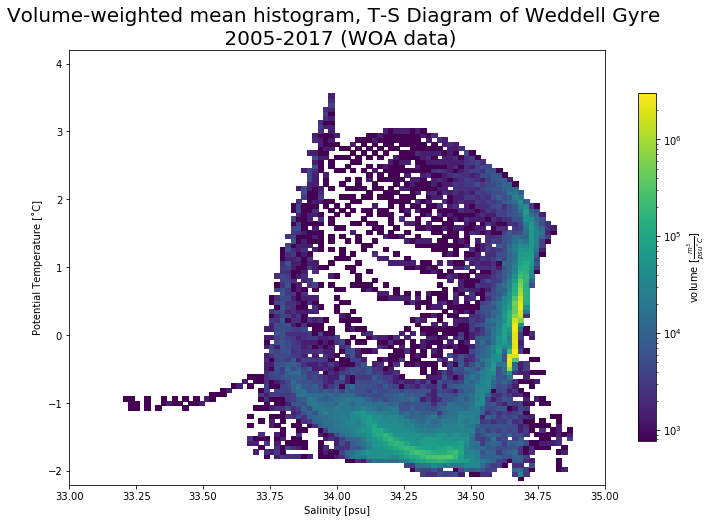

In [41]:
ts_hist_0517 = histogram(temp_0517, salt_0517, bins=[theta_bins, salt_bins]) / (delta_salt * delta_theta)
#ts_hist_0517.where(ts_hist_0517>0).plot(norm=LogNorm(), figsize=(12,8), 
#                                        cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

## Plotting TS differences